<a href="https://colab.research.google.com/github/dhirenmalik/comp3710-demo-2/blob/main/COMP37104_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [ ]:
!pip -q install gdown
# Use the full share link with --fuzzy OR just the file ID between /d/ and /view
LINK = "https://drive.google.com/file/d/1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp/view?usp=sharing"  # <-- paste your link
!gdown --fuzzy "$LINK" -O /content/oasis.zip
!unzip -q /content/oasis.zip -d /content/OASIS

Downloading...
From (original): https://drive.google.com/uc?id=1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp
From (redirected): https://drive.google.com/uc?id=1iR_E2j5Td0pzkokWg45yfG_zRsvrHdYp&confirm=t&uuid=c11ac7ce-dffc-4aab-9718-55dae08545e0
To: /content/oasis.zip
100% 270M/270M [00:04<00:00, 55.8MB/s]
replace /content/OASIS/keras_png_slices_data/keras_png_slices_seg_test/seg_441_slice_0.nii.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# ==== Setup ====
!pip -q install torch torchvision --upgrade

import os, glob, random, math, re
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# ---- Multi-class settings ----
INCLUDE_BACKGROUND = True        # set True if you want background as a 5th class
BACKGROUND_RAW_VAL = 0           # change if your background is some other value
IGNORE_INDEX = 255               # used when excluding background
MAX_MASKS_TO_SCAN = 5000         # for class discovery / weights

# Repro
def set_seed(s=1337):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(1337)

IMG_DIRS = [
    "keras_png_slices_train",
    "keras_png_slices_validate",
    "keras_png_slices_test",
]
MASK_DIRS = [
    "keras_png_slices_seg_train",
    "keras_png_slices_seg_validate",
    "keras_png_slices_seg_test",
]

DATA_ROOT = "/content/OASIS/keras_png_slices_data"

# 1) Robust key normalizer and subject extractor
def key_from_name(name: str) -> str:
    """
    Normalize to '###_slice_###' (lowercase, prefixes removed).
    Examples:
      seg_457_slice_9.nii.png  -> '457_slice_9'
      case_457_slice_9.nii.png -> '457_slice_9'
      img_402_slice_12.png     -> '402_slice_12'
    """
    base = os.path.basename(name).lower()
    # strip composite extensions first
    if base.endswith('.nii.png'): base = base[:-8]
    elif base.endswith('.png'):   base = base[:-4]
    if base.endswith('.nii'):     base = base[:-4]
    # remove common prefixes
    for pref in ('seg_', 'case_', 'img_', 'image_', 'mask_', 'label_'):
        if base.startswith(pref):
            base = base[len(pref):]
    # ensure pattern <id>_slice_<k>
    m = re.search(r'(\d+)_slice_(\d+)$', base)
    return f"{m.group(1)}_slice_{m.group(2)}" if m else base

def subject_from_key(k: str) -> str:
    m = re.match(r'(\d+)_slice_\d+$', k)
    return m.group(1) if m else None


def scan_index(root, subdirs):
    idx = {}
    for sub in subdirs:
        for p in Path(root, sub).glob("*.png"):
            k = key_from_name(p.name)
            if k not in idx:                 # first-hit wins
                idx[k] = str(p)
    return idx

img_index  = scan_index(DATA_ROOT, IMG_DIRS)     # key -> image path
mask_index = scan_index(DATA_ROOT, MASK_DIRS)    # key -> mask path

def discover_raw_labels(mask_paths, k=MAX_MASKS_TO_SCAN):
    sample = mask_paths if len(mask_paths) <= k else random.sample(mask_paths, k)
    seen = set()
    for p in sample:
        a = np.array(Image.open(p))
        if a.ndim == 3: a = a[...,0]
        seen |= set(np.unique(a).tolist())
    raw_vals = sorted(int(v) for v in seen)
    return raw_vals

all_mask_paths = list(mask_index.values())
RAW_LABELS = discover_raw_labels(all_mask_paths)
print("RAW_LABELS found in masks:", RAW_LABELS)

def build_label_mapping(raw_labels, include_bg, bg_val):
    # ensure background is first (if present)
    ordered = []
    if bg_val in raw_labels:
        ordered.append(bg_val)
    ordered += [v for v in raw_labels if v != bg_val]

    if include_bg:
        value_to_class = {v:i for i,v in enumerate(ordered)}
        num_classes = len(ordered)
        ignore_index = None
        eval_include_bg = True
    else:
        # map background to IGNORE_INDEX, others to 0..(C-1)
        value_to_class = {ordered[0]: IGNORE_INDEX} if ordered and ordered[0]==bg_val else {}
        for i,v in enumerate(ordered):
            if v == bg_val: continue
            value_to_class[v] = i - (1 if bg_val in raw_labels else 0)  # compact to 0..C-1
        num_classes = len(ordered) - (1 if bg_val in raw_labels else 0)
        ignore_index = IGNORE_INDEX
        eval_include_bg = False
    return value_to_class, num_classes, ignore_index, eval_include_bg

VALUE_TO_CLASS, NUM_CLASSES, CE_IGNORE_INDEX, METRICS_INCLUDE_BG = build_label_mapping(
    RAW_LABELS, INCLUDE_BACKGROUND, BACKGROUND_RAW_VAL
)

print("VALUE_TO_CLASS (raw -> class):", VALUE_TO_CLASS)
print("NUM_CLASSES:", NUM_CLASSES, "| ignore_index:", CE_IGNORE_INDEX, "| metrics include_bg:", METRICS_INCLUDE_BG)
assert NUM_CLASSES >= 2, "Expected >=2 non-background classes."

def scan_keys_for_subdir(root, subdir):
    p = Path(root, subdir)
    files = list(p.rglob("*.png")) + list(p.rglob("*.PNG"))
    return { key_from_name(f.name) for f in files }

# mask-defined splits (only keys that actually exist in those mask folders)
train_mask_keys = scan_keys_for_subdir(DATA_ROOT, "keras_png_slices_seg_train")
val_mask_keys   = scan_keys_for_subdir(DATA_ROOT, "keras_png_slices_seg_validate")
test_mask_keys  = scan_keys_for_subdir(DATA_ROOT, "keras_png_slices_seg_test")

img_keys = set(img_index.keys())
mask_keys = set(mask_index.keys())

# Only keep keys that have BOTH an image and a mask
train_keys = sorted((train_mask_keys & img_keys) & mask_keys)
val_keys   = sorted((val_mask_keys   & img_keys) & mask_keys)
test_keys  = sorted((test_mask_keys  & img_keys) & mask_keys)

train_pairs = [(img_index[k], mask_index[k]) for k in train_keys]
val_pairs   = [(img_index[k], mask_index[k]) for k in val_keys]
test_pairs  = [(img_index[k], mask_index[k]) for k in test_keys]

print(f"Slices -> train: {len(train_pairs)} | val: {len(val_pairs)} | test: {len(test_pairs)}")

# Subject counts per split (zero-padded for display)
def sids(pairs):
    def sid_from_pair(pm):
        return subject_from_key(key_from_name(os.path.basename(pm[1])))
    return sorted({ sid_from_pair(pm) for pm in pairs })

tr_s, va_s, te_s = sids(train_pairs), sids(val_pairs), sids(test_pairs)
fmt = lambda ss: [f"{int(s):03d}" for s in ss][:10]  # show first 10, 3-digit padded
print("Subjects -> train:", len(tr_s), "val:", len(va_s), "test:", len(te_s))
print("Example train subjects:", fmt(tr_s))
print("Example val subjects  :", fmt(va_s))
print("Example test subjects :", fmt(te_s))

# Optional: verify each subject has 32 slices (warn if not)
from collections import Counter
def check_32(pairs, name):
    c = Counter(subject_from_key(key_from_name(os.path.basename(m))) for _, m in pairs)
    bad = {sid: n for sid, n in c.items() if n != 32}
    if bad:
        print(f"[{name}] Non-32-slice subjects (showing up to 10):", list(bad.items())[:10])
    else:
        print(f"[{name}] All subjects have 32 slices.")
check_32(train_pairs, "train"); check_32(val_pairs, "val"); check_32(test_pairs, "test")

RAW_LABELS found in masks: [0, 85, 170, 255]
VALUE_TO_CLASS (raw -> class): {0: 0, 85: 1, 170: 2, 255: 3}
NUM_CLASSES: 4 | ignore_index: None | metrics include_bg: True
Slices -> train: 9664 | val: 1120 | test: 544
Subjects -> train: 302 val: 35 test: 17
Example train subjects: ['001', '002', '003', '004', '005', '006', '007', '009', '010', '011']
Example val subjects  : ['402', '403', '404', '405', '406', '407', '408', '409', '410', '411']
Example test subjects : ['441', '442', '443', '444', '445', '446', '447', '448', '449', '450']
[train] All subjects have 32 slices.
[val] All subjects have 32 slices.
[test] All subjects have 32 slices.


In [ ]:
def estimate_class_weights(mask_paths, mapper, ignore_index, k=MAX_MASKS_TO_SCAN):
    counts = Counter()
    sample = mask_paths if len(mask_paths) <= k else random.sample(mask_paths, k)
    for p in sample:
        a = np.array(Image.open(p))
        if a.ndim == 3: a = a[...,0]
        for raw, cls in mapper.items():
            if cls == ignore_index:
                continue
            counts[cls] += int((a == raw).sum())
    total = sum(counts.values())
    freqs = np.array([counts[c]/max(total,1) for c in range(NUM_CLASSES)], dtype=np.float32)
    w = 1.0 / (freqs + 1e-8)
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

CLASS_WEIGHTS = estimate_class_weights(all_mask_paths, VALUE_TO_CLASS, CE_IGNORE_INDEX)
print("CLASS_WEIGHTS:", CLASS_WEIGHTS.tolist())

CLASS_WEIGHTS: [0.14784173667430878, 1.92003333568573, 0.9366955757141113, 0.9954293370246887]


In [ ]:
from torchvision.transforms.functional import InterpolationMode

class OASISSegDataset(Dataset):
    def __init__(self, pairs, augment=False, value_to_class=None, ignore_index=None):
        self.pairs = pairs
        self.augment = augment
        self.value_to_class = value_to_class
        self.ignore_index = ignore_index

    @staticmethod
    def _read_img(path):
        with Image.open(path) as im:
            arr = np.array(im)
        arr = arr.astype(np.float32)
        if arr.ndim == 3:
            arr = arr.mean(axis=2)
        # scale to [0,1] if raw
        mx = arr.max() if arr.max() > 0 else 1.0
        arr = arr / max(1.0, mx) if mx > 1 else arr
        return arr

    def _read_mask(self, path):
        with Image.open(path) as im:
            arr = np.array(im)
        if arr.ndim == 3:
            arr = arr[...,0]
        # map raw -> class index (or ignore_index for background if excluding)
        tgt = np.full_like(arr, fill_value=(self.ignore_index if self.ignore_index is not None else 0), dtype=np.int64)
        for raw, cls in self.value_to_class.items():
            if cls == self.ignore_index:
                tgt[arr == raw] = self.ignore_index
            else:
                tgt[arr == raw] = cls
        return tgt

    def __len__(self): return len(self.pairs)

    def _random_tf(self, img, msk):
      """
      img: (1,H,W) float
      msk: (H,W)   long (class indices)
      """
      # Pack mask to CHW float for geometric ops
      m = msk.unsqueeze(0).float()  # (1,H,W)

      # Horizontal / vertical flips
      if random.random() < 0.5:
          img = TF.hflip(img); m = TF.hflip(m)
      if random.random() < 0.5:
          img = TF.vflip(img); m = TF.vflip(m)

      # Small rotation
      if random.random() < 0.5:
          angle = random.uniform(-10, 10)
          # use bilinear for image, NEAREST for label map; fill background as 0
          img = TF.rotate(img, angle,
                          interpolation=InterpolationMode.BILINEAR,
                          fill=0)
          m   = TF.rotate(m,   angle,
                          interpolation=InterpolationMode.NEAREST,
                          fill=0)

      # Unpack + cast back to class indices
      msk = m.squeeze(0).round().long()
      return img, msk

    def __getitem__(self, i):
        img_path, mask_path = self.pairs[i]
        img = self._read_img(img_path)      # (H,W) float32
        msk = self._read_mask(mask_path)    # (H,W) int64 (class indices or ignore)

        img = torch.from_numpy(img).unsqueeze(0).float()  # (1,H,W)
        msk = torch.from_numpy(msk).long()                # (H,W)

        if self.augment:
            img, msk = self._random_tf(img, msk)

        # per-slice z-normalization
        mean = img.mean()
        std  = img.std().clamp(min=1e-6)
        img = (img - mean) / std

        return img, msk

In [ ]:
# ==== DataLoaders ====
BATCH_SIZE = 16
NUM_WORKERS = 2

ds_train = OASISSegDataset(train_pairs, augment=True,  value_to_class=VALUE_TO_CLASS, ignore_index=CE_IGNORE_INDEX)
ds_val   = OASISSegDataset(val_pairs,   augment=False, value_to_class=VALUE_TO_CLASS, ignore_index=CE_IGNORE_INDEX)
ds_test  = OASISSegDataset(test_pairs,  augment=False, value_to_class=VALUE_TO_CLASS, ignore_index=CE_IGNORE_INDEX)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)
dl_val   = DataLoader(ds_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)
dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=False)

print(f"Datasets -> train {len(ds_train)}, val {len(ds_val)}, test {len(ds_test)}")

Datasets -> train 9664, val 1120, test 544


In [ ]:
# --- Confirm GPU & enable Ampere/A100-friendly knobs ---
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Compute capability:", torch.cuda.get_device_capability(0))
    print("CUDA version (runtime):", torch.version.cuda)

    # Let cuDNN pick fastest kernels for fixed 256×256 shapes
    torch.backends.cudnn.benchmark = True

    # Ampere+ TF32: good speed/accuracy trade-off for convs & matmuls
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # Optional (PyTorch 2.x): compile graph for extra speed
    # (place after you construct the model and before training)
    # model = torch.compile(model)  # uncomment if using PyTorch 2.x


CUDA available: True
GPU: NVIDIA A100-SXM4-40GB
Compute capability: (8, 0)
CUDA version (runtime): 12.6


In [ ]:
# ==== UNet ====
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, deconv=True):
        super().__init__()
        if deconv:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
                nn.Conv2d(in_ch, out_ch, 1, bias=False),
            )
        self.conv = DoubleConv(out_ch*2, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        # handle odd shapes
        dh = skip.size(2) - x.size(2)
        dw = skip.size(3) - x.size(3)
        if dh or dw:
            x = F.pad(x, [dw//2, dw-dw//2, dh//2, dh-dh//2])
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

# ---- UNet change: output NUM_CLASSES channels ----
class UNet(nn.Module):
    def __init__(self, in_ch=1, base=64, num_classes=NUM_CLASSES):
        super().__init__()
        self.e1 = DoubleConv(in_ch, base)
        self.e2 = DoubleConv(base, base*2)
        self.e3 = DoubleConv(base*2, base*4)
        self.e4 = DoubleConv(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.bott = DoubleConv(base*8, base*16)
        self.u4 = UpBlock(base*16, base*8)
        self.u3 = UpBlock(base*8, base*4)
        self.u2 = UpBlock(base*4, base*2)
        self.u1 = UpBlock(base*2, base)
        self.head = nn.Conv2d(base, num_classes, 1)  # <-- here

    def forward(self, x):
        s1 = self.e1(x)
        s2 = self.e2(self.pool(s1))
        s3 = self.e3(self.pool(s2))
        s4 = self.e4(self.pool(s3))
        b  = self.bott(self.pool(s4))
        x  = self.u4(b, s4)
        x  = self.u3(x, s3)
        x  = self.u2(x, s2)
        x  = self.u1(x, s1)
        return self.head(x)  # logits (N, C, H, W)

# ---- Loss & multi-class metrics ----
ce_kwargs = dict()
if CE_IGNORE_INDEX is not None:
    ce_kwargs["ignore_index"] = CE_IGNORE_INDEX
criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHTS.to(device), **ce_kwargs)

def multiclass_dice(logits, target, num_classes, include_bg=True, ignore_index=None, eps=1e-6):
    # logits: (N,C,H,W), target: (N,H,W)
    pred = torch.argmax(logits, dim=1)            # (N,H,W)
    dices = []
    classes = range(num_classes) if include_bg else range(1, num_classes)
    for c in classes:
        if ignore_index is not None:
            mask = (target != ignore_index)
            p = ((pred==c) & mask).float()
            t = ((target==c) & mask).float()
        else:
            p = (pred==c).float()
            t = (target==c).float()
        inter = (p*t).sum()
        union = p.sum() + t.sum()
        dices.append((2*inter + eps) / (union + eps))
    return torch.stack(dices).mean() if len(dices) else torch.tensor(0.0, device=logits.device)

def multiclass_iou(logits, target, num_classes, include_bg=True, ignore_index=None, eps=1e-6):
    pred = torch.argmax(logits, dim=1)
    ious = []
    classes = range(num_classes) if include_bg else range(1, num_classes)
    for c in classes:
        if ignore_index is not None:
            mask = (target != ignore_index)
            p = ((pred==c) & mask).float()
            t = ((target==c) & mask).float()
        else:
            p = (pred==c).float()
            t = (target==c).float()
        inter = (p*t).sum()
        union = p.sum() + t.sum() - inter
        ious.append((inter + eps) / (union + eps))
    return torch.stack(ious).mean() if len(ious) else torch.tensor(0.0, device=logits.device)


# # ==== Dice, IoU, and loss ====
# def dice_coef(pred, target, eps=1e-6):
#     # pred: logits (N,1,H,W); target: (N,1,H,W) in {0,1}
#     prob = torch.sigmoid(pred)
#     pred_bin = (prob > 0.5).float()
#     inter = (pred_bin * target).sum(dim=(1,2,3))
#     union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
#     dice = (2*inter + eps) / (union + eps)
#     return dice.mean()

# def iou_coef(pred, target, eps=1e-6):
#     prob = torch.sigmoid(pred)
#     pred_bin = (prob > 0.5).float()
#     inter = (pred_bin * target).sum(dim=(1,2,3))
#     union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - inter
#     iou = (inter + eps) / (union + eps)
#     return iou.mean()

# class DiceLoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__(); self.eps = eps
#     def forward(self, logits, targets):
#         probs = torch.sigmoid(logits)
#         num = 2 * (probs * targets).sum(dim=(1,2,3)) + self.eps
#         den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
#         return 1 - (num / den).mean()

# bce = nn.BCEWithLogitsLoss()
# dice_loss = DiceLoss()

# def combo_loss(logits, targets, alpha=0.5):
#     return alpha * bce(logits, targets) + (1-alpha) * dice_loss(logits, targets)

In [ ]:
from tqdm.auto import tqdm
import time

try:
    from torch.amp import autocast, GradScaler
except Exception:
    # fallback for older torch
    from torch.cuda.amp import autocast, GradScaler

amp_enabled = torch.cuda.is_available()
scaler = GradScaler(device='cuda' if amp_enabled else 'cpu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_ch=1, base=64, num_classes=NUM_CLASSES).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def run_epoch(loader, train=True):
    model.train(mode=train)
    tot_loss = tot_dice = tot_iou = 0.0
    n_pix = 0
    for imgs, target in tqdm(loader, desc="train" if train else "eval", total=len(loader)):
        imgs   = imgs.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)
        with autocast('cuda', enabled=amp_enabled):
            logits = model(imgs)                 # (N,C,H,W)
            loss = criterion(logits, target)     # CE with optional ignore
        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        with torch.no_grad():
            dice = multiclass_dice(logits, target, NUM_CLASSES, include_bg=METRICS_INCLUDE_BG, ignore_index=CE_IGNORE_INDEX)
            iou  = multiclass_iou (logits, target, NUM_CLASSES, include_bg=METRICS_INCLUDE_BG, ignore_index=CE_IGNORE_INDEX)
        bs = imgs.size(0)
        tot_loss += loss.item() * bs
        tot_dice += dice.item() * bs
        tot_iou  += iou.item() * bs
        n_pix    += bs
    return tot_loss/n_pix, tot_dice/n_pix, tot_iou/n_pix

EPOCHS = 12
best = -1; ckpt_path = "/content/unet_oasis_mc_best.pt"
for ep in range(1, EPOCHS+1):
    tr_loss, tr_dice, tr_iou = run_epoch(dl_train, train=True)
    va_loss, va_dice, va_iou = run_epoch(dl_val,   train=False)
    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} dice {tr_dice:.4f} iou {tr_iou:.4f} || "
          f"val loss {va_loss:.4f} dice {va_dice:.4f} iou {va_iou:.4f}")
    score = va_dice
    if score > best:
        best = score
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ↳ Saved {ckpt_path}")

# Final test
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.to(device).eval()
te_loss, te_dice, te_iou = run_epoch(dl_test if len(ds_test) else dl_val, train=False)
print("\n=== Final Evaluation (macro, "
      f"{'incl' if METRICS_INCLUDE_BG else 'excl'} background) ===")
print(f"Loss: {te_loss:.4f} | Dice: {te_dice:.4f} | IoU: {te_iou:.4f}")

train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 01 | train loss 0.1760 dice 0.9159 iou 0.8535 || val loss 0.0944 dice 0.9412 iou 0.8946
  ↳ Saved /content/unet_oasis_mc_best.pt


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 02 | train loss 0.1101 dice 0.9343 iou 0.8812 || val loss 0.0814 dice 0.9430 iou 0.8971
  ↳ Saved /content/unet_oasis_mc_best.pt


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 03 | train loss 0.1004 dice 0.9404 iou 0.8911 || val loss 0.1080 dice 0.9416 iou 0.8935


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 04 | train loss 0.0956 dice 0.9436 iou 0.8963 || val loss 0.0764 dice 0.9559 iou 0.9185
  ↳ Saved /content/unet_oasis_mc_best.pt


train:   0%|          | 0/604 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 05 | train loss 0.0919 dice 0.9460 iou 0.9003 || val loss 0.0712 dice 0.9546 iou 0.9164


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 06 | train loss 0.0881 dice 0.9482 iou 0.9040 || val loss 0.0981 dice 0.9549 iou 0.9158


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 07 | train loss 0.0869 dice 0.9488 iou 0.9050 || val loss 0.0640 dice 0.9530 iou 0.9136


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 08 | train loss 0.0843 dice 0.9502 iou 0.9075 || val loss 0.0630 dice 0.9599 iou 0.9254
  ↳ Saved /content/unet_oasis_mc_best.pt


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 09 | train loss 0.0821 dice 0.9513 iou 0.9094 || val loss 0.0605 dice 0.9578 iou 0.9217


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10 | train loss 0.0819 dice 0.9514 iou 0.9095 || val loss 0.0819 dice 0.9501 iou 0.9075


train:   0%|          | 0/604 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0><function _MultiProcessingDataLoaderIter.__del__ at 0x7a7056b51da0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        self._shutdown_workers()
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 11 | train loss 0.0793 dice 0.9529 iou 0.9122 || val loss 0.0712 dice 0.9534 iou 0.9140


train:   0%|          | 0/604 [00:00<?, ?it/s]

eval:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 12 | train loss 0.0781 dice 0.9537 iou 0.9134 || val loss 0.0576 dice 0.9602 iou 0.9259
  ↳ Saved /content/unet_oasis_mc_best.pt


eval:   0%|          | 0/34 [00:00<?, ?it/s]


=== Final Evaluation (macro, incl background) ===
Loss: 0.0553 | Dice: 0.9613 | IoU: 0.9277


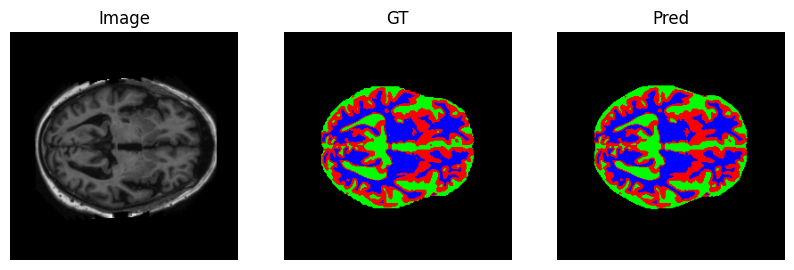

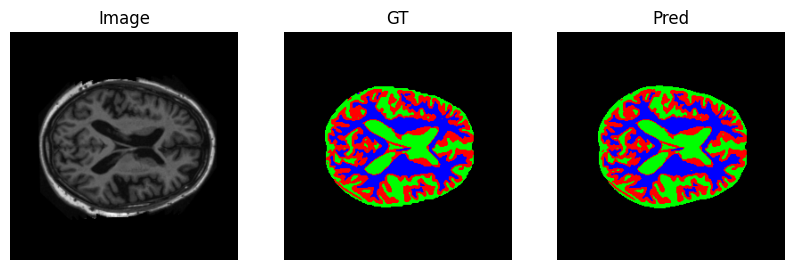

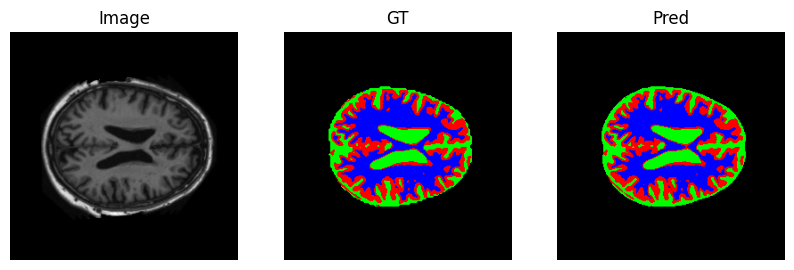

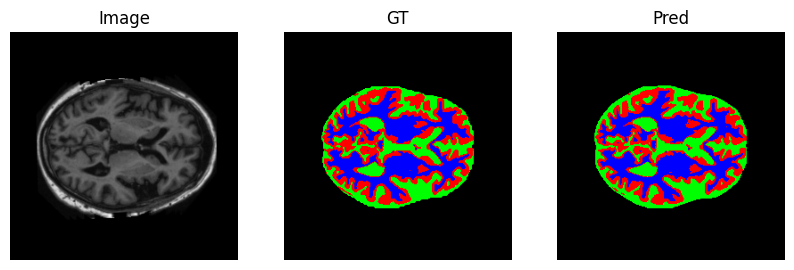

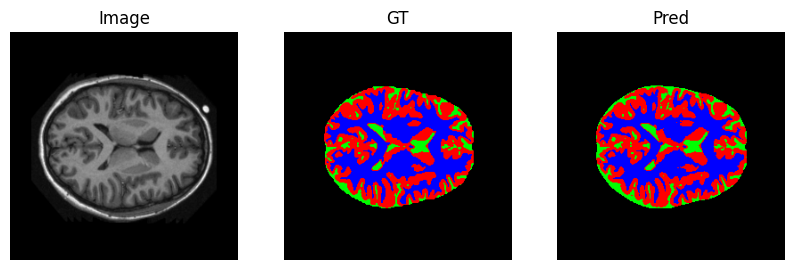

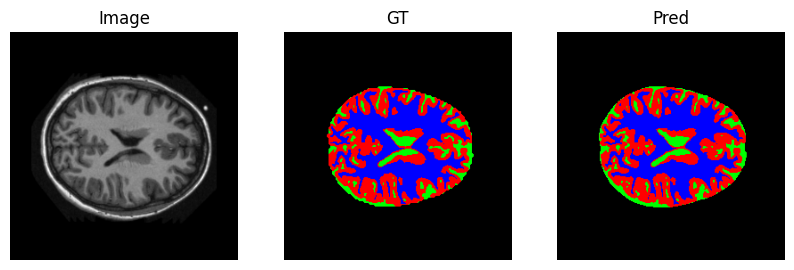

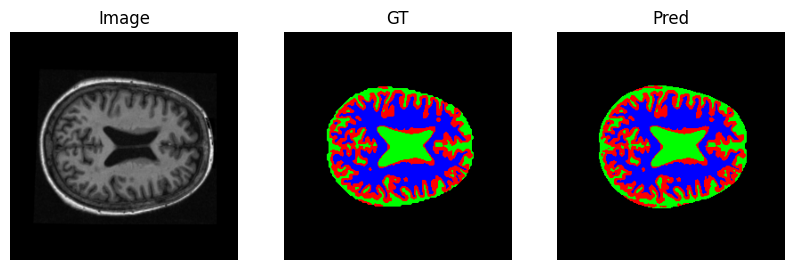

In [ ]:
# import matplotlib.pyplot as plt

# def show_batch(loader, k=3):
#     model.eval()
#     imgs, masks = next(iter(loader))
#     imgs  = imgs[:k].to(device)
#     masks = masks[:k].to(device)
#     with torch.no_grad():
#         logits = model(imgs)
#         probs  = torch.sigmoid(logits)
#         preds  = (probs > 0.5).float()

#     imgs  = imgs.cpu().numpy()
#     masks = masks.cpu().numpy()
#     preds = preds.cpu().numpy()

#     for i in range(k):
#         plt.figure(figsize=(9,3))
#         plt.subplot(1,3,1); plt.title("Image"); plt.axis('off')
#         plt.imshow(imgs[i,0], cmap='gray')
#         plt.subplot(1,3,2); plt.title("Mask"); plt.axis('off')
#         plt.imshow(masks[i,0], cmap='gray')
#         plt.subplot(1,3,3); plt.title("Pred"); plt.axis('off')
#         plt.imshow(preds[i,0], cmap='gray')
#         plt.show()

# # Uncomment to preview a few from val or test
# show_batch(dl_val if len(ds_val) else dl_test, k=3)
import matplotlib.pyplot as plt
import numpy as np

# simple fixed palette for 5 colors (bg + 4 classes). Adjust as needed.
PALETTE = np.array([
    [0,0,0],        # background
    [0,255,0],      # class 1
    [255,0,0],      # class 2
    [0,0,255],      # class 3
    [255,255,0],    # class 4
], dtype=np.uint8)

def colorize(mask_2d, include_bg=INCLUDE_BACKGROUND):
    # mask_2d is class indices (H,W); if background was ignored, it isn't present in preds
    m = mask_2d.copy()
    if not include_bg:
        # for visualization, pretend bg is class 0 where target==ignore (if any)
        pass
    m = np.clip(m, 0, PALETTE.shape[0]-1)
    return PALETTE[m]

def show_mc(dataset, idx=0):
    img, tgt = dataset[idx]
    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1)[0].cpu().numpy()

    im  = img[0].cpu().numpy()
    tcm = colorize(tgt.cpu().numpy())
    pcm = colorize(pred)

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.title("Image"); plt.axis('off'); plt.imshow(im, cmap='gray')
    plt.subplot(1,3,2); plt.title("GT");    plt.axis('off'); plt.imshow(tcm)
    plt.subplot(1,3,3); plt.title("Pred");  plt.axis('off'); plt.imshow(pcm)
    plt.show()

show_mc(ds_test, 0)
show_mc(ds_test, 10)
show_mc(ds_test, 20)
show_mc(ds_test, 30)
show_mc(ds_test, 40)
show_mc(ds_test, 50)
show_mc(ds_test, 400)
